### Batch Normalzation原理解释和优点？

Batch normalization 是一种解决深度神经网络层数太多, 而没办法有效前向传递(forward propagate)的问题. 因为每一层的输出值都会有不同的 均值(mean) 和 方差(deviation), 所以输出数据的分布也不一样, 如下图, 从左到右是每一层的输入数据分布, 上排的没有 Batch normalization, 下排的有 Batch normalization.
![image](week3/batch_normalization1.png)

** 数据标准化的原因：**  
在神经网络中，数据分布对训练都会产生影响。（原因：在神经网络中存在激活函数这种非线性变化的部分）。利用tanh为例;当某个权重W的初始值为0.1，x=1，这样后层神经元的计算结果就是Wx=0.1;如果说x=20;那么Wx=2。 当经过激活函数的时候，输出的值接近为0.1和1。当输出为1的时候已经进入了神经元的饱和状态了，这个时候，激活函数的导数为0,根据chain-rule可知导数会为零。当x增大，tanh的激活函数的输出还是1，那这个时候这些大于20的数据对神经网络权重的调整已经没有效果了。也就是说这些样本对整个网络的训练已经失效了。 所以项通过normalization的处理，让x变化范围不会太大，让输入值经过激励函数的敏感的部分。  

在神经网络的输入层和隐含层都会出现有上述的问题， 但是对于隐含层不能直接做normalization的处理，所以，我们采用batch normalization来处理这种情况。  

batch normalization添加在激活函数前一层，也就是将一个训练的batch数据在前向传播的时候，对每层都进行normalization的处理,然后再传递到激励函数（在这个部分，暂时我看到的是说将BN添加到全连接层和激励函数之间;补充：论文中说BN可以用于CNN和全连接层，可以运用到网络中的任意激活层）。  

** BN算法 **
我们引入一些 batch normalization 的公式. 这三步就是我们在刚刚一直说的 normalization 工序, 但是公式的后面还有一个反向操作, 将 normalize 后的数据再扩展和平移. 原来这是为了让神经网络自己去学着使用和修改这个扩展参数 gamma, 和 平移参数 β, 这样神经网络就能自己慢慢琢磨出前面的 normalization 操作到底有没有起到优化的作用, 如果没有起到作用, 我就使用 gamma 和 beta 来抵消一些 normalization 的操作.这里gamma和beta是可以选择的值，所以网络可以根据自己的需要来恢复这个normalization的参数。
![image](week3/BNalgorithm.png)
最后我们来看看一张神经网络训练到最后, 代表了每层输出值的结果的分布图. 这样我们就能一眼看出 Batch normalization 的功效啦. 让每一层的值在有效的范围内传递下去.
![image](week3/BNperformance.png)

** 论文摘要 **  
BN可以让网络有更大的learning_rates(原因：避免了让训练数据陷在非线性变换的饱和区间）。BN会让参数增长能够稳定下来。

BN对模型有正则效果：这个点子由来与mini-batch的训练。模型的泛化能力会变好。

加速BN网络的方法：  
* 增大learning_rate，这个做法没有副作用。
* 移除Dropout：因为BN与Dropout有同样的功效。在BN-Inception网络当中，移除Dropout训练更快，并且不会过拟合。
* 减少二阶范数的正则： BN-Inception中权重减小为5.
* 加速learning_rate的衰减,利用指数衰减。相交Inception训练速度快。
* 移除local response normalization。  
 （LRN局部归一化：对局部神经元的活性创建竞争机制，使得其中响应比较大的值变得相对更大，并抑制其他反馈较小的神经元，增强模型的泛化能力 tf.nn.lrn。实质上是对模型做了平滑处理，让识别率提高了）。  
 $$ b_{x,y}^{i} = a_{x,y}^{i}/(k+\alpha\sum_{j = max(0,i-n/2)}^{min(N-1,i+n/2)}(a_{x,y}^{j})^{2})^{\beta}$$ 
 这个公式当中，a表示第i个核在位置(x,y)运用ReLu等非线性神经元输出，n是同一位置上面临近的kernel map的数目，N是kernel的总数。 k = 2, n = 5, alpha=1e-4, beta=0.75，利用不同的核的平滑(在2015年也有提出LRN在大规模的图像识别中没有效果） 
* 在训练的过程中每次对训练的样本进行洗牌。  
* 减小图片的distortion（photometric distortion)。为了防止过拟合，一般我们会对数据进行增强处理，这个时候可能会对数据进行反转之类的操作，在这里，我们需要减少这种操作，让图片大部分保持为原来的状态。  

下面的实验尝试的过程当中，BN对tanh的改善好于ReLU，但是这个数据集不代表所有数据。

** 优点 **
1.  提高梯度在网络中的流动。Normalization能够使特征全部缩放到[0,1]，这样在反向传播时候的梯度都是在1左右，避免了梯度消失现象。
2. 提升学习速率。归一化后的数据能够快速的达到收敛。
3. 减少模型训练对初始化的依赖。

参考文献：  
https://morvanzhou.github.io/tutorials/machine-learning/tensorflow/5-13-BN/  
https://arxiv.org/pdf/1502.03167.pdf(原始论文地址）  
https://zhuanlan.zhihu.com/p/23906526

In [73]:
# BN实践

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

ACTIVATION = tf.nn.tanh #每一层的激活函数都使用relu
N_LAYERS = 7 #设置7层网络
N_HIDDEN_UNITS = 30 # 隐含层都设置为30

In [74]:
def plot_his(inputs, inputs_norm):
    # 唯美一层的输入画直方图
    for j, all_inputs in enumerate([inputs,inputs_norm]):
        for i, inPut in enumerate(all_inputs):
            # 这里的数据是网络的输入层和7层网络的输出，所以总共有8个子图
            plt.subplot(2, len(all_inputs), j*len(all_inputs)+(i+1))
            plt.cla()
            if i == 0:
                the_range = (-7,10)
            else:
                the_range = (-1,1)
            plt.hist(inPut.ravel(), bins=15, range = the_range, color = 'lightblue')
            plt.yticks(())
            if j == 1:
                plt.xticks(the_range)
            else:
                plt.xticks(())
            ax = plt.gca()
            ax.spines['right'].set_color('none')
            ax.spines['top'].set_color('none')
        plt.title("%s normalizing"%("Without" if j == 0 else "With"))
    plt.draw()
    plt.pause(0.01)
    
def fix_seed(seed = 1):
    '''
    可重复性
    '''
    np.random.seed(seed)
    tf.set_random_seed(seed)
    
    
def add_layer(inputs, in_size, out_size, activation_function=None,norm=False,on_train=True):
    '''
    增添网络层
    '''
    # xs[n_samples,n_features],w:[n_features,n_outputs],b:[1,n_output]
    Weights = tf.Variable(tf.random_normal([in_size, out_size], mean=0.0,stddev=1.0))
    biases = tf.Variable(tf.zeros([1, out_size])+0.1)
    Wx_plus_b = tf.matmul(inputs, Weights) + biases
    
    # Batch Normalization
    if norm:
        # 利用momments来做batch_normalization;tf.nn.moments(x,axes,shift,name,keep_dims)，返回x的均值和方差。
        # 利用卷积核做global normalization，拥有的shape[batch, height, width, depth],传递参数axes[0,1,2]
        # 简单的batch normalization就直接传递参数axes[0]
        # 想要 normalize 的维度, [0] 代表 batch 维度
        # 如果是图像数据, 可以传入 [0, 1, 2], 相当于求[batch, height, width] 的均值/方差, 注意不要加入 channel 维度
        # 公式： scale*(x-mu)/（sigma+epsilon) + shift
        fc_mean, fc_var = tf.nn.moments(Wx_plus_b,axes=[0])
        scale = tf.Variable(tf.ones([out_size])) # 尺度
        shift = tf.Variable(tf.zeros([out_size])) # 偏移量
        epsilon = 0.001 # 防止被零除
        '''
        由于使用batch进行每次的更新，所以每个batch的mean/var都不一样，所以使用滑动平均的方法来提升训练的稳定度
        '''
        ema = tf.train.ExponentialMovingAverage(decay=0.5)
        def mean_var_with_update():
            ema_apply_op = ema.apply([fc_mean, fc_var])
            with tf.control_dependencies([ema_apply_op]):# ema_apply_op必须在return操作前jinxing计算
                return tf.identity(fc_mean), tf.identity(fc_var)
            # 如果直接赋值的化会失效，这里必须要用tf.identity(),因为对与control_dependecies这个管理器，只有当里面的操作是一个op时候才会生效。
            # 也就是线执行传入参数的op，再窒息你该context中的op，但是如果直接return这个值的化就不是定义的op，在图中不会形成一个节点，也就会失效。
            # tf.identity是返回一个一模一样的新的tensor的op，这样就会增加一个新的节点到graph当中，这是的cotrol——dependecies就会生效。
            # 注意"="在tensorflow当中只是一个简单赋值，并不是定义的op，所以不会加到图中，例如mean=fc_mean，这个操作不会添加到图中。
        
        # 根据新的 batch 数据, 记录并稍微修改之前的 mean/var
        mean,var = mean_var_with_update() 
        '''
        由于在test和train阶段的情况不一样，所以添加on_train参数，将on_train定义成全局变量表示在训练阶段
        
        # tf.cond(pred, true_fn, false_fn)
        #True， 更新mean/var# False，返回之前fc_mean//fc_var的moving average
        #bool类型，True/False
        mean,var = tf.cond(on_train, 
                          mean_var_with_update,
                          lambda:(ema.average(fc_mean), ema.average(fc_var)))
        '''
        Wx_plus_b = tf.nn.batch_normalization(Wx_plus_b, mean, var, shift, scale, epsilon)
        # 上面那一步, 在做如下事情:
        # Wx_plus_b = (Wx_plus_b - fc_mean) / tf.sqrt(fc_var + 0.001)
        # Wx_plus_b = Wx_plus_b * scale + shift
        # 如果你已经看不懂了, 请去我最上面学习资料里的链接 (我制作的 Batch normalization 简介视频)
        
    if activation_function is None:
        outputs = Wx_plus_b
    else:
        outputs = activation_function(Wx_plus_b)
    return outputs
    
def build_net(xs, ys, norm):
    '''
    搭建神经网络
    '''
    fix_seed(1)
    # 对第一层采用BN
    if norm:
        fc_mean,fc_var = tf.nn.moments(xs, axes=[0])
        scale = tf.Variable(tf.ones([1]))
        shift = tf.Variable(tf.zeros([1]))
        epsilon = 0.01
        ema = tf.train.ExponentialMovingAverage(decay=0.5)
        
        def mean_var_with_update():
            ema_apply_op = ema.apply([fc_mean, fc_var])
            with tf.control_dependencies([ema_apply_op]):
                return tf.identity(fc_mean), tf.identity(fc_var)
        
        mean, var = mean_var_with_update()
        xs = tf.nn.batch_normalization(xs, mean, var, shift, scale, epsilon)
      
    # 每一层记录输入
    # 利用一个list来存放每一层的输入
    layers_inputs = [xs]
    
    for l_n in range(N_LAYERS):
        layer_input = layers_inputs[l_n]
        in_size = layers_inputs[l_n].get_shape()[1].value
        
        output = add_layer(layer_input, in_size, N_HIDDEN_UNITS, ACTIVATION, norm)
        layers_inputs.append(output)
        
    # 建立输出层
    prediction = add_layer(layers_inputs[-1],N_HIDDEN_UNITS,1,activation_function=None)
    
    cost = tf.reduce_mean(tf.reduce_sum(tf.square(ys-prediction),reduction_indices=[1]))
    train_op = tf.train.GradientDescentOptimizer(.001).minimize(cost)
    return [train_op, cost, layers_inputs]


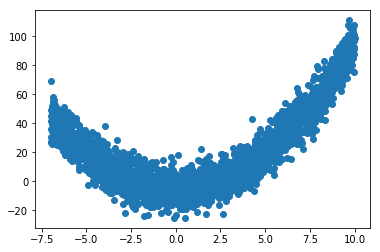

In [67]:
# 创建数据
fix_seed(1)

x_data = np.linspace(-7,10,2500)[:,np.newaxis]
np.random.shuffle(x_data)
noise = np.random.normal(0,8,x_data.shape)
y_data = np.square(x_data) - 5 + noise

# plot inputdata
plt.scatter(x_data, y_data)
plt.show()

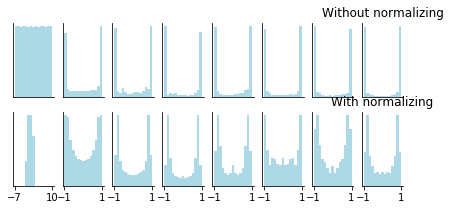

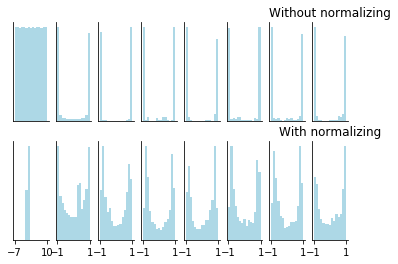

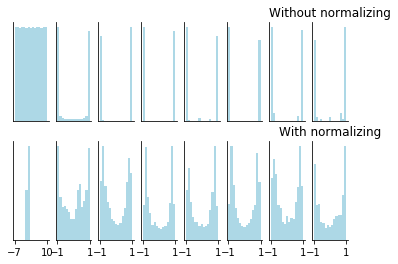

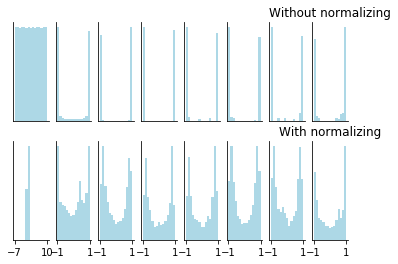

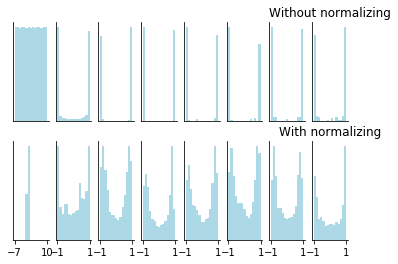

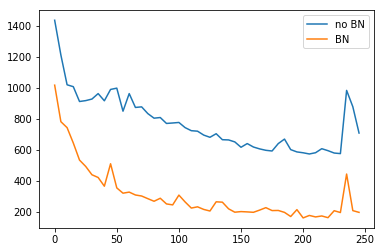

In [75]:
xs = tf.placeholder(tf.float32, [None, 1])
ys = tf.placeholder(tf.float32, [None, 1])

train_op, cost, layers_inputs = build_net(xs,ys,norm=False)
train_op_norm, cost_norm, layers_inputs_norm = build_net(xs,ys,norm=True)

sess = tf.Session()
if int((tf.__version__).split('.')[1]) <12 and int((tf.__version__).split('.')[0]) < 1:
    init = tf.initialize_all_variables()
else:
    init = tf.global_variables_initializer()
sess.run(init)

# record cost
cost_his = []
cost_his_norm = []
record_step = 5

plt.ion()
plt.figure(figsize=(7,3))
for i in range(250):
    if i%50 == 0:
        # 画直方图
        all_inputs, all_inputs_norm = sess.run([layers_inputs, layers_inputs_norm], feed_dict={xs:x_data,ys:y_data})
        # print(len(all_inputs), len(all_inputs_norm))
        plot_his(all_inputs, all_inputs_norm)
        
    # train on batch
    sess.run([train_op, train_op_norm], feed_dict={xs:x_data[i*10:i*10+10],ys:y_data[i*10:i*10+10]})
    
    if i % record_step == 0:
        cost_his.append(sess.run(cost, feed_dict={xs:x_data,ys:y_data}))
        cost_his_norm.append(sess.run(cost_norm, feed_dict = {xs:x_data,ys:y_data}))
        
plt.ioff()
plt.figure()
# 这里我运行出来最后cost_his的计算出现溢出的问题
plt.plot(np.arange(len(cost_his))*record_step, np.array(cost_his),label='no BN') # no norm
plt.plot(np.arange(len(cost_his_norm))*record_step, np.array(cost_his_norm), label='BN')
plt.legend()
plt.show()
sess.close()

### 如何理解卷积？
卷积的计算实际上就是针对图片不同的位置进行相同的权重相乘。  
首先定义一个卷积核的大小，以及卷积核中间的参数。每一个固定的filter相当与一个固定的目标的特征量。也就是我们想要通过这个filter查看这个图片是否具有我们所需要提取的特征。针对每一个filter我们采用平移的方式对这个图片的各个未知进行Wx+b的计算，最终得到卷积值。这个卷积值代表的就是这个图片的这个区域被当前的filter激活的情况。通过不同的stride的设置，可以实现图片的下采样。 针对一个filter，当前层输出的是一个通道的filter map，代表的是这个图片针对当前的filter的激活的程度，也就是是否具有当前的这个filter特征的程度。最后当前卷积层输出的通道数目对应的就是filter的个数。  
卷积一般都是采用的方形的filter。定一个图片的大小是N\*N, filter的大小是F\*F,如果说想要卷积后输出的图片的大小不变，可以先对图片做zero-padding，zero-padding是将图片外围填充宽度为P的0值。 这样填充之后的图片的大小是(N+2P)\*(N+2P)。假设卷积的步长是stride,那么卷积之后，输出的图片的宽度是：  
floor((N+2P-F)/stride) + 1,可以根据这个公式计算P的值的大小。  

** 针对卷积的理解就是设计不同的filter提取不同的特征，也就是卷积是做特征提取的过程。**  
___

### 如何理解卷积神经网络的卷积（Convolution Kernel)和池化（Pooling）,有哪些池化？
* kernel也就是上面所提到的filter。一个kernel可以设计一个想要提取的特征，这个kernel针对当前图片的输出就是feature map，也就是特征图片。  
* Pooling:实际上是降采样的过程，这个操作的目地是为了减少参数的数量，达到减轻过拟合的目标。这一过程其实在CNN中通过stride的设计也可以得到。现在在实践中也会这么做。一般Pooling会采取max-pooling，主要原因是我们想要寻求这个图片当中被这个kernel激活得最厉害的区域。所以我们一般采用max-pooling。 

池化作用补充： 
* 池化引入了输入近似不变的特性。 就是当输入做少量平移的时候，经过池化之后的输出大部分不会改变。 局部的平移不变是一个非常有用的性质， 尤其是当我们关心某个特征是否出现而不关心它的具体的未知的时候。   
 池化可以看作是一个无限增强的先验：这一层学得的函数必须具有对少量平移的不变性。当这个假设成立，pooling可以极大提高网络的统计效率。(这个特征也就是增加了鲁棒性）。
* 处理多任务中，池化对于处理不同的输入也具有重要的作用。如果说想对不同大小的图像进行分类，分类层的输入必须是固定的大小，通常通过调整池化区域的偏置大小来实现。这样池化之后即使输入不同也会收到相同数量的统计特征。

> pooling的种类：常见的池化函数包括最大池化，相邻矩形区域内的平均值，L2范数，以及基于据中文像素距离的加权平均数，一般最常采用max-pooling

___

### learning_rate应该如何选取，过大或者过小的影响？
learning_rate应当根据当前的梯度以及迭代情况来决定大小，不合适的权重对训练的影响都不好。
![image](/home/lily/Datageek/week3/learning_rate.jpeg)
从上图当中可以看出，如果说learning_rate设置过大，那么可能已经超过了最优质，但是如果learning_rate设置得过小，那么学习的效率就会很慢，需要迭代的次数就会更多。所以要合理设置合适大小的值。根据这个原因，提出了多种更改learning_rate的学习的办法，详细查看下面的不同的梯度下降的算法。  

___

###  各种梯度下降算法的优缺点（也就是优化方法）。
* SGD 随机梯度下降算法。就是针对训练数据，我们不一次全部计算所有的梯度，而是在一个epoch当中，训练完所有的参数，每一次只选择一个样本进行训练。这样训练在梯度下降当中加入了随机性，让训练过程当中避免陷入局部最小值，但是这个方法的缺点是因为每一次梯度更新只和当前的样本相关，随机性太强，因此很不稳定。mini-batch的训练就是基于SGD的基础上，但是mini-batch由于每一次的参数个数相较于一个样本会多，所以说mini-batch的训练会比单个样本的训练稍微稳定一点。在GPU中采用mini-batch的训练可以对训练进行提速，因为GPU的并行计算能力，不同的batch是同时计算的，但是batch_size的设置不能过大，因为过大的batch_size会超过GPU的内存，会导致运行出错。  
 ___
 这个算法的关键参数是学习率
 
* momentum 动量梯度下降：这个算法的来源于牛顿定律，基本思想加入惯性的作用，如果说陷入了局部的最小值，可以由于这个惯性的作用跳出这个局部最小值。
 ___
 tf.train.MomentumOptimizer()  
 动量的主要目的是为了解决两个问题，一个是Hessian矩阵的病态条件，一个是随机梯度的方差。当数据的维度尺寸不一样的时候，梯度下降可能会出现zig-zag路线。（Hessian矩阵的病态条件也就是不同的尺度的二次导数的尺度不一样，也就是这个原因导致了zig-zag路线）。
 
* Adagrad(adaptive gradient optimization):
 根据前面累计的梯度的值的均方值（平方和的平均值开根号），以及相关的基于时间的learning_rate的衰减，更新现在的learning_rate。Adagrad因为引入了时间衰减项(因为上下分子分母抵消，所以无法看出来),导致了训练到后面的速度会非常的慢，因为在达到最优解之前，learning_rate就已经衰减得非常小了。  
 ___
 tf.train.AdagradOptimizer()  
 
* Adam（adaptive moments)：
 属于现在比较稳定的梯度下降的办法,结合了RMSProp梯度下降的算法，并且加入了梯度的一阶矩（动量项）和二阶距的估计（非中心项）。
 ___
 tf.train.AdamOptimizer()  
 
* RMSProp:  
 基于Adagrad的基础上修改，为了让梯度的算法在非凸的情况下更好（大多数情况下，神经网络都不是严格的凸函数）。这里将梯度的累计变为指数加权移动平均。拥有二阶项，但缺少优化银子
 ___
 tf.train.RMSPropOptimizer()
 ![image](week3/gradientOptimizer.jpg)
 ![image](week3/gradientOptimizer2.jpg)
 
___
### 机器学习中，有哪些正则化的方法？目的是什么？Dropout的好处是？
机器学习中，一般采用的正则的方法有L1范数，L2范数，一般采用L2的范数其实相当于是Weight decay也就是权重衰减。L1范数的方法具有特征选择的功能，但是L2范数只能够减少权重的值，让权重值的大小基本上接近0,而不能等于0。实际L2范数也可以看成是weight decay也就是权重的衰减。  
在树的方法中中，正则的方法是剪枝，也就是保证树的叶节点的个数不会过多，以此达到正则的目地。  

正则的目的：  
由于当选用的模型过于复杂的时候，这样的假设集合目标群体太大，泛化能力会变差，容易导致过拟合（也就是说容易拟合噪声）。加入正则就是降低目标集合群，防止过拟合，提升模型的泛化能力。  

Dropout:
1. 由于每次用输入网络的样本进行权值更新时，隐含节点都是以一定概率随机出现，因此不能保证每2个隐含节点每次都同时出现，这样权值的更新不再依赖于有固定关系隐含节点的共同作用，阻止了某些特征仅仅在其它特定特征下才有效果的情况。
2. 可以将dropout看作是模型平均的一种。对于每次输入到网络中的样本（可能是一个样本，也可能是一个batch的样本），其对应的网络结构都是不同的，但所有的这些不同的网络结构又同时share隐含节点的权值。这样不同的样本就对应不同的模型，是bagging的一种极端情况。个人感觉这个解释稍微靠谱些，和bagging，boosting理论有点像，但又不完全相同。
3. native bayes是dropout的一个特例。Native bayes有个错误的前提，即假设各个特征之间相互独立，这样在训练样本比较少的情况下，单独对每个特征进行学习，测试时将所有的特征都相乘，且在实际应用时效果还不错。而Droput每次不是训练一个特征，而是一部分隐含层特征。
4. 还有一个比较有意思的解释是，Dropout类似于性别在生物进化中的角色，物种为了使适应不断变化的环境，性别的出现有效的阻止了过拟合，即避免环境改变时物种可能面临的灭亡。

Dropout的好处就是防止过拟合，由于dropout可以看作是模型的平均，所以选择dropout这个trick的时候，一般用的激活函数都是偏向于线性的激活函数。

在神经网络当中采用的正则的方法和机器学习中不一样，L2正则实际上对神经网络起到的作用比较小，所以神经网络的正则有以下方法：  
1. Batch Normalization(实际上，一般会首先采用这种正则的方法，一般最开始只用着一种，不够才会再加dropout）。
2. Dropout(在全连接层是采用随机的某些单元置零，在CNN网络层一般是将某些的整个的feature map置零），测试的时候利用所有测试的数据的结果的期望。
3. DropConnect(这里类似Dropout,但是Dropout是把激活函数置零，这里是将权重置零，结果类似）。
4. Fractional Max Pooling：不常用，就是在每次池化的时候随机选择池化的区域，最后的在测试的时候取平均，降低随机性。
5. 数据增强。
6. 随机神经网络的深度：就是在训练的时候，随机省略某些层不训练，最终结果是使用整个网络。  

参考文献：  
http://www.cnblogs.com/tornadomeet/p/3258122.html
___

### 如何理解“过拟合 overfitting”? 神经网络训练，如何避免overfitting?
过拟合：模型在训练集上能够得到很好的结果，但是这个模型在测试集上的表现很差，说明发生了过拟合现象。所以神经网络的结果不好不一定是过拟合，有可能是根本没有训练起来，在训练机上的效果就表现得很差。针对神经网络的过拟合的判断一定要查看训练集的效果。  
如何避免：
1. Early stopping：将训练集的正确率与测试集的正确率进行对比，由于随着训练加深，训练集的loss 值会不断提高，但是会发生过拟合现象，导致测试集的loss值先下降再上升。一般的做法是分出一个validation set，将训练的模型在这个数据集上进行预测，找到在validation set中loss值最低模型，而不是训练集中loss值最低的模型。
2. 在loss函数里面添加正则项，也就是增添L1，L2范数。（正则化）
3. Dropout
4. data augment（数据增强）这样可以训练模型抵抗噪声的能力，实际上我觉着可以防止过拟合。这里有人提出实际上是一种增加样本集合的办法。  
5. 增加样本数量。  
6. 降低模型的复杂性。  
参考文献：  
http://www.cnblogs.com/unclelin/p/6384608.html
___
### 如何理解Momentum？weight decay?他们在神经网络中训练的作用是什么？ 
Momentum：实际商是共轭梯度法的近似，是通过历史搜索方法对当前梯度方向的修正来抵消在ill-conditioned问题上的来回震荡，也就是ill-Hessian矩阵出现的zig-zag的问题。可以加快网络的训练的速度。

参考文献：  
https://www.zhihu.com/question/24529483

weight decay：是权重衰减，实际上是参数正则的过程，在损失函数添加L2范数实际就是做了weight decay。在神经网络的训练当中可以防止过拟合，增加泛化能力。  

___

### Covariate Shift 和 Internal Covariate Shift如何理解？
Covariate shift： 
训练集和测试集中X的概率密度不一样。  
一般用于迁移学习的领域。假设x是属于特征空间的某一样本点，y是标签。covariate这个词，其实就是指这里的x，那么covariate shift可以直接根据字面意思去理解：样本点x的变化。  
假设q1（x）是测试集中一个样本点的概率密度，q0（x）是训练集中一个样本点的概率密度。最终我们估计一个条件概率密度p(y|x，θ)，它由x和一组参数θ=｛θ1，θ2......θm｝所决定。对于一组参数来说，对应loss(θ)函数评估性能的好坏
综上，当我们找出在q0（x）分布上最优的一组θ\'时，能否保证q1（x）上测试时也最好呢？
传统机器学习假设训练集和测试集是独立同分布的，即q0（x）=q1（x），所以可以推出最优θ'依然可以保证q1（x）最优。但现实当中这个假设往往不成立，伴随新数据产生，老数据会过时，当q0（x）不再等于q1（x）时，就被称作covariate shift

二、怎么解决covariate shift？  
以上已经知道一个样本点分别在训练集和测试集上的概率密度q0（x）和q1（x），实际当中的解决方案是附加一个由x决定的权值。通过这个附加的权值，拟合出新的数据。  

使得在训练过程当中对于q1（x）很大或者q0（x）很小的样本视作“重要”样本，这样的样本是有益于测试集预测的，我们应该尽量把它分类正确。而对于q1（x）很小或者q0（x）很大的样本，它只是被时代遗弃的“老数据”，这些样本对于模型训练的意义也是无关紧要了.
***
Internal Convariate Shift: 这个概念在Batch Normalization这篇论文中有提到。论文中数由于深度神经网络每层输入的分布在训练的过程会发生变化，因为前面层数会发生变化，就通过设置比较小的learning rate并且对参数的初始化进行好的调节来减慢训练，但是由于神经网络还具有饱和的非线性激活函数，这样子模型的训练就非常的困难。由于网络参数的变化，将internal convariate shift定义为网络激活分布的变化。 为了改善训练，寻求减少内部协变量的转移。  
在训练过程中，每一层的激活值的分布随着网络训练时参数的变化而变化，当输入值为一个很大的正数或者负数时，会导致激活值的分布趋于非线性饱和区，如 sigmoid函数两头梯度几乎为0，这就会导致梯度消失。可以用Batch Normalization的方式来解决。  

参考文献：  
https://www.google.com.hk/search?client=ubuntu&channel=fs&q=covariate+shift&ie=utf-8&oe=utf-8&gws_rd=cr,ssl  
http://noahsnail.com/2017/09/04/2017-9-4-Batch%20Normalization%E8%AE%BA%E6%96%87%E7%BF%BB%E8%AF%91%E2%80%94%E2%80%94%E4%B8%AD%E6%96%87%E7%89%88/  
https://zhuanlan.zhihu.com/p/26352087  
***



### LeNet5模型的详细解释
![image](week3/LeNet5.png)
C1层：paper作者，选择6个特征卷积核，然后卷积核大小选择5\*5，这样我们可以得到6个特征图，然后每个特征图的大小为32-5+1=28，也就是神经元的个数为6\*28\*28=784。

S2层：这就是下采样层，也就是使用最大池化进行下采样，池化的size，选择(2,2)，也就是相当于对C1层28\*28的图片，进行分块，每个块的大小为2\*2，这样我们可以得到14\*14个块，然后我们统计每个块中，最大的值作为下采样的新像素，因此我们可以得到S1结果为：14\*14大小的图片，共有6个这样的图片。经过sigmoid函数进行映射。

C3层：卷积层，这一层我们选择卷积核的大小依旧为5\*5，据此我们可以得到新的图片大小为14-5+1=10，然后我们希望可以得到16张特征图。那么问题来了？这一层是最难理解的，我们知道S2包含：6张14\*14大小的图片，我们希望这一层得到的结果是：16张10\*10的图片。

S4层：下采样层，比较简单，也是知己对C3的16张10\*10的图片进行最大池化，池化块的大小为2\*2。因此最后S4层为16张大小为5\*5的图片。至此我们的神经元个数已经减少为：16\*5\*5=400。激活函数是sigmoid。

C5层：我们继续用5\*5的卷积核进行卷积，然后我们希望得到120个特征图。这样C5层图片的大小为5-5+1=1，也就是相当于1个神经元，120个特征图，因此最后只剩下120个神经元了。这个时候，神经元的个数已经够少的了，后面我们就可以直接利用全连接神经网络，进行这120个神经元的后续处理，后面具体要怎么搞，只要懂多层感知器的都懂了，不解释。

F6 全连接层， 含有84个隐层节点， 激活函数sigmoid

F7 dense layer： output 10类，softmax回归。

总结：

* Lenet5 含有三个卷积层，两个池化层，再加上1个全连接层。

* 每个卷积层都包含： 卷积、池化、非线性激活函数映射

参考文献：  
https://blog.csdn.net/d5224/article/details/68928083  
http://www.cnblogs.com/hejunlin1992/p/8449449.html

心得：  
注意不要把op的名字和赋值的参数名字弄成一样，这样子tensorflow会报错。  
调参魅力无穷啊，adam的learning_rate从0.001调整到0.0001，正确率提升了80%，可怕。


In [85]:
import os
import struct
import numpy as np

def load_mnist(path, kind='train'):
    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,'%s-labels.idx1-ubyte'% kind)
    images_path = os.path.join(path,'%s-images.idx3-ubyte' % kind)
    
    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II',lbpath.read(8))
        labels = np.fromfile(lbpath,dtype=np.uint8)

    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack('>IIII', imgpath.read(16))
        images = np.fromfile(imgpath, dtype=np.uint8).reshape(len(labels), 784)

    return images, labels

In [108]:
import tensorflow as tf
import numpy as np

# implementaion of LeNet5
# 构建7层网络结构， conv1,max_pooling1,conv2,max_pooling2, conv3,dense_layer1, dense_layer2(softmax)

def conv_and_pooling(input_layer,filters, kernel_size, pool_size, strides_conv,strides_pool, padding_conv="valid",padding_pool = "valid"):
    # Convolutional Layer #1
    conv1 = tf.layers.conv2d(inputs = input_layer,strides=strides_conv, filters = filters, kernel_size=kernel_size, padding=padding_conv)
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size= pool_size, padding=padding_pool,strides=strides_pool)
    output = tf.nn.relu(pool1)
    return output

def LeNet_model_fn(x, y):
    '''
    mode : TRAIN， EVAL， PREDICT
    '''
    # Input layer
    input_layer = tf.reshape(x, [-1,28,28,1])
    c_and_p1 = conv_and_pooling(input_layer,6,[5,5],[2,2],1,2,padding_conv='same')
    c_and_p2 = conv_and_pooling(c_and_p1,16,[5,5],[2,2],1,2)
    conv3 = tf.layers.conv2d(inputs = c_and_p2, filters = 120, strides = 1,kernel_size=[5,5], padding="valid")
    # dense layer
    conv3_flat = tf.reshape(conv3, [-1, 1*1*120])
    dense = tf.layers.dense(inputs=conv3_flat, units=84, activation=tf.nn.relu)
    dropout = tf.layers.dropout(inputs = dense, rate=0.5)
    logits = tf.layers.dense(inputs=dropout, units=10)
    
    y = tf.one_hot(indices = tf.cast(y, tf.int32), depth=10)
    
    predictions = {
        "classes" : tf.argmax(logits, axis=1),
        "probabilities" : tf.nn.softmax(logits, name="softmax_tensor")
    }
    loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = predictions["probabilities"],labels = y))
    loss1 = tf.reduce_mean(tf.reduce_sum(-y*tf.log(predictions["probabilities"]),axis=1))
    accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(y,1),predictions["classes"]), tf.float32))
    train_op = tf.train.AdamOptimizer(0.0001,0.9,0.999,1e-8).minimize(loss)
    
    return [loss,loss1,accuracy,predictions,train_op]
    
    """
    这里调用了tensorflow子集定义的estimator类
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)
    
    loss = tf.loss.sparse_softmax_cross_entropy(labels=y, logits=logits)
    
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.GradientDesentOptimizer(learning_rate=0.001)
        train_op = optimizer.minimize(loss=loss, global_step = tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)
    
    if mode == tf.estimator.ModeKeys.EVAL:
        eval_metric_ops = {
            "accuracy" :tf.metrics.accuracy(labels=y, predictions=predictions["classes"])
        }
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)
    """

In [110]:
if __name__ == "__main__": 
    train_epochs = 30
    batch_size = 100
    display_step = 1
    
    images,y_train = load_mnist('/home/lily/Datageek/MNIST_data','train')
    X_test,y_test = load_mnist('MNIST_data','t10k')
    
    x = tf.placeholder(tf.float32, [None, 784])
    y = tf.placeholder(tf.float32, [None])
    [loss,loss1,accuracy,predictions,train_op] = LeNet_model_fn(x,y)
    init = tf.global_variables_initializer()
    #n_samples = len(images)
    with tf.Session() as sess:
        sess.run(init)
        
        for epoch in range(train_epochs):
            avg_loss = 0
            avg_loss1 = 0
            if  len(images) % batch_size == 0:
                batches = len(images) // batch_size
            else:
                batches = len(images) // batch_size + 1
            for i in range(batches):
                if (i+1)*batch_size <= len(images):
                    # 注意前面los的名称不能和后面的loss相同，否则会报错
                    _, los,los1 = sess.run([train_op, loss,loss1], feed_dict={x:images[i*batch_size:(i+1)*batch_size],
                                                         y:y_train[i*batch_size:(i+1)*batch_size]})
                else:
                    _, los,los1 = sess.run([train_op, loss, loss1], feed_dict={x:images[i*batch_size:],
                                                         y:y_train[i*batch_size:]})
                avg_loss += los/batches
                avg_loss1 += los1/batches
            
            if (epoch+1) % display_step == 0:
                print("epoch %d, avg loss %g"%(epoch+1, avg_loss))
               #  print("epoch %d, avg loss %g"%(epoch+1, avg_loss1))
    
        train_accuracy = accuracy.eval(feed_dict={x:images, y:y_train})
        print("training accuracy %g"%(train_accuracy))
        test_accuracy = accuracy.eval(feed_dict={x:X_test, y:y_test})                
        print("test accuracy %g"%(train_accuracy))

epoch 1, avg loss 0.708542
epoch 2, avg loss 0.690544
epoch 3, avg loss 0.687382
epoch 4, avg loss 0.676157
epoch 5, avg loss 0.669394
epoch 6, avg loss 0.668412
epoch 7, avg loss 0.66798
epoch 8, avg loss 0.66768
epoch 9, avg loss 0.66326
epoch 10, avg loss 0.657181
epoch 11, avg loss 0.656928
epoch 12, avg loss 0.656854
epoch 13, avg loss 0.656702
epoch 14, avg loss 0.656555
epoch 15, avg loss 0.656449
epoch 16, avg loss 0.65641
epoch 17, avg loss 0.656335
epoch 18, avg loss 0.656279
epoch 19, avg loss 0.656272
epoch 20, avg loss 0.656126
epoch 21, avg loss 0.656175
epoch 22, avg loss 0.656079
epoch 23, avg loss 0.656033
epoch 24, avg loss 0.655976
epoch 25, avg loss 0.655944
epoch 26, avg loss 0.655934
epoch 27, avg loss 0.655894
epoch 28, avg loss 0.655834
epoch 29, avg loss 0.65581
epoch 30, avg loss 0.655844
training accuracy 0.993933
test accuracy 0.993933


In [94]:
x

<tf.Tensor 'Placeholder_82:0' shape=(?, 784) dtype=float32>

In [107]:
images.shape

(60000, 784)

In [49]:
y_test.shape

(10000,)

array([[1, 1, 1],
       [2, 0, 2]])

array([[ True,  True,  True],
       [ True, False,  True]])

In [ ]:
''